#  Local Regression Results

This notebook evaluates local regression under 2 factors:
- Kernel type: RBF and Laplacian (positive, distance-based kernels suitable for weighting)
- Dimensionality reduction: with vs without PCA

Evaluation :
1. Hold out a test set once (never used for tuning to prevent leakage).
2. Tune hyperparameters (γ) using k-fold CV on the remaining dev set.
3. Refit on the full dev set and evaluate once on the held-out test set.

Outputs:
- `results/tables/lr_results.csv`
- Figures under `results/figures/local_regression/`

Note:

Given the size of the dataset (more than 20k data points), it is infeasible to perform, for each kernel, for each gamma, and for each cross-validation fold, a full local regression run, because local regression requires computing kernel weights and solving a local model for every query point, leading to prohibitively high computational cost.
Due to this, a change was made: we subsample the full dataset. This is the simplest and most practical fix, and it is appropriate because local regression methods are designed for small-to-medium-sized datasets and are commonly evaluated on subsets in practice.
Another option we considered but did not implement is k-nearest-neighbor (k-NN) truncation, where only the k nearest training points are used per query instead of the full dataset; however, this would introduce an additional hyperparameter (k) that would also require tuning, which is beyond the scope of this project.
A third option was to reduce the number of cross-validation folds and the number of gamma values, but this would lead to unstable hyperparameter selection and less reliable performance estimates, making the results harder to interpret and defend.

In [1]:
# Imports + path setup

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.models.local_regression import LocalRegression
from src.kernels.rbf import RBFKernel
from src.kernels.laplacian import LaplacianKernel
from src.config import SEED, TEST_SIZE, K_FOLDS
from src.evaluation.splits import (train_test_split_indices, kfold_indices)
from src.evaluation.metrics import (rmse, mae)

# Make project root importable
PROJECT_ROOT = Path.cwd().resolve().parents[0]
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))

# Paths
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
FIG_DIR = RESULTS_DIR / "figures" / "local_regression"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
np.random.seed(SEED)

GAMMAS = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]


In [3]:
# Load preprocessed data

X_scaled = np.load(DATA_DIR / "X_scaled.npy")
X_pca = np.load(DATA_DIR / "X_pca.npy")

y = np.load(DATA_DIR / "y.npy")


assert X_scaled.shape[0] == y.shape[0]
assert X_pca.shape[0] == y.shape[0]

print("X_scaled:", X_scaled.shape)
print("X_pca:", X_pca.shape)
print("y:", y.shape)


X_scaled: (21263, 81)
X_pca: (21263, 17)
y: (21263,)


In [7]:
# Subsampling for local regression (for computational feasibility)

LR_SUBSAMPLE_SIZE = 2000

rng = np.random.default_rng(SEED)
sub_idx = rng.choice(len(y), size=LR_SUBSAMPLE_SIZE, replace=False)

X_scaled_lr = X_scaled[sub_idx]
X_pca_lr = X_pca[sub_idx]
y_lr = y[sub_idx]

print("Subsampled shapes:")
print("X_scaled_lr:", X_scaled_lr.shape)
print("X_pca_lr   :", X_pca_lr.shape)
print("y_lr       :", y_lr.shape)


Subsampled shapes:
X_scaled_lr: (2000, 81)
X_pca_lr   : (2000, 17)
y_lr       : (2000,)


In [12]:
# Core: tune gamma with k-fold on dev set, then evaluate once on held-out test set

def tune_gamma_cv(X_dev, y_dev, kernel_cls, gammas, k=5, seed=42):
    rows = []
    n = X_dev.shape[0]
    for gamma in gammas:
        fold_rmses = []
        fold_maes = []
        for tr_idx, va_idx in kfold_indices(n, k=k, seed=seed):
            X_tr, y_tr = X_dev[tr_idx], y_dev[tr_idx]
            X_va, y_va = X_dev[va_idx], y_dev[va_idx]

            model = LocalRegression(kernel=kernel_cls(gamma=gamma))
            model.fit(X_tr, y_tr)
            preds = model.predict(X_va)

            fold_rmses.append(rmse(y_va, preds))
            fold_maes.append(mae(y_va, preds))

        rows.append({
            "gamma": float(gamma),
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std": float(np.std(fold_rmses, ddof=1)) if len(fold_rmses) > 1 else 0.0,
            "cv_mae_mean": float(np.mean(fold_maes)),
            "cv_mae_std": float(np.std(fold_maes, ddof=1)) if len(fold_maes) > 1 else 0.0,
        })

    df = pd.DataFrame(rows).sort_values("cv_rmse_mean", ascending=True).reset_index(drop=True)
    best_gamma = float(df.loc[0, "gamma"])
    return best_gamma, df

def fit_and_test(X_dev, y_dev, X_test, y_test, kernel_cls, gamma):
    model = LocalRegression(kernel=kernel_cls(gamma=gamma))
    model.fit(X_dev, y_dev)
    preds = model.predict(X_test)
    return {
        "test_rmse": rmse(y_test, preds),
        "test_mae": mae(y_test, preds),
    }

In [14]:
# Run experiments for both representations: scaled vs PCA

dev_idx, test_idx = train_test_split_indices(len(y_lr), test_size=TEST_SIZE, seed=SEED)

def run_condition(X, y, representation_name):
    X_dev, y_dev = X[dev_idx], y[dev_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    configs = [
        ("rbf", RBFKernel),
        ("laplacian", LaplacianKernel),
    ]

    all_results = []
    cv_curves = {}

    for kernel_name, kernel_cls in configs:
        best_gamma, cv_df = tune_gamma_cv(X_dev, y_dev, kernel_cls, GAMMAS, k=K_FOLDS, seed=SEED)
        test_metrics = fit_and_test(X_dev, y_dev, X_test, y_test, kernel_cls, best_gamma)

        result_row = {
            "model": "local_regression",
            "kernel": kernel_name,
            "representation": representation_name,  # "scaled" or "pca"
            "best_gamma": best_gamma,
            **test_metrics,
            # Also record CV summary at chosen gamma (mean/std)
            "cv_rmse_mean_at_best": float(cv_df[cv_df["gamma"] == best_gamma]["cv_rmse_mean"].iloc[0]),
            "cv_rmse_std_at_best": float(cv_df[cv_df["gamma"] == best_gamma]["cv_rmse_std"].iloc[0]),
            "cv_mae_mean_at_best": float(cv_df[cv_df["gamma"] == best_gamma]["cv_mae_mean"].iloc[0]),
            "cv_mae_std_at_best": float(cv_df[cv_df["gamma"] == best_gamma]["cv_mae_std"].iloc[0]),
        }
        all_results.append(result_row)
        cv_curves[(representation_name, kernel_name)] = cv_df

        print(f"[{representation_name} | {kernel_name}] best_gamma={best_gamma:.4g} "
              f"CV_RMSE={result_row['cv_rmse_mean_at_best']:.4g} "
              f"TEST_RMSE={result_row['test_rmse']:.4g}")

    return pd.DataFrame(all_results), cv_curves

results_scaled, cv_scaled = run_condition(X_scaled_lr, y_lr, "scaled")
results_pca, cv_pca = run_condition(X_pca_lr, y_lr, "pca")

results_df = pd.concat([results_scaled, results_pca], ignore_index=True)
results_df

[scaled | rbf] best_gamma=0.01 CV_RMSE=16.33 TEST_RMSE=15.31
[scaled | laplacian] best_gamma=0.1 CV_RMSE=15.44 TEST_RMSE=13.99
[pca | rbf] best_gamma=0.1 CV_RMSE=16.18 TEST_RMSE=15.12
[pca | laplacian] best_gamma=0.1 CV_RMSE=17.79 TEST_RMSE=17.46


,model,kernel,representation,best_gamma,test_rmse,test_mae,cv_rmse_mean_at_best,cv_rmse_std_at_best,cv_mae_mean_at_best,cv_mae_std_at_best
0,local_regression,rbf,scaled,0.01,15.314159,11.106052,16.332542,0.886078,11.836233,0.710500
1,local_regression,laplacian,scaled,0.10,13.991014,8.949406,15.440027,1.166236,10.131029,0.827083
2,local_regression,rbf,pca,0.10,15.118897,9.821704,16.175607,1.016083,10.824277,0.576926
3,local_regression,laplacian,pca,0.10,17.463844,12.493910,17.790869,0.769063,13.116841,0.534864


In [15]:
# Save results table
out_csv = TABLES_DIR / "lr_results.csv"
results_df.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")

Saved: /Users/dimanavihrenova/Desktop/kernel-regression-dim-reduction/results/tables/lr_results.csv


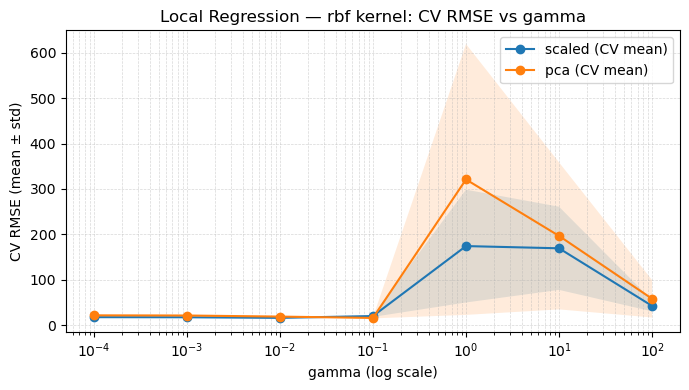

Saved: /Users/dimanavihrenova/Desktop/kernel-regression-dim-reduction/results/figures/local_regression/cv_rmse_vs_gamma_rbf.png


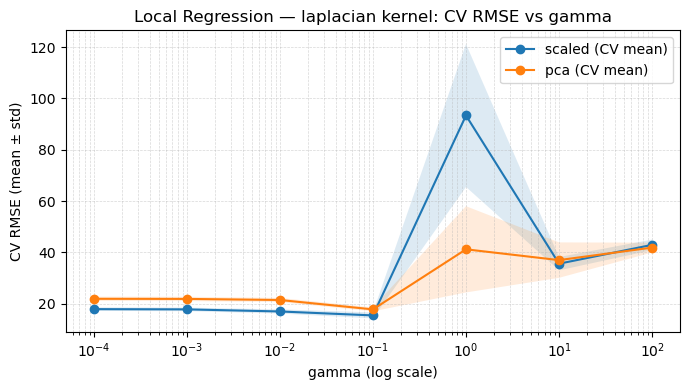

Saved: /Users/dimanavihrenova/Desktop/kernel-regression-dim-reduction/results/figures/local_regression/cv_rmse_vs_gamma_laplacian.png


In [16]:
# Plot CV curves: RMSE vs gamma (log scale), by kernel with PCA/no-PCA overlay

def plot_cv_curves(cv_curves, kernel_name):
    fig, ax = plt.subplots(figsize=(7, 4))

    for rep in ["scaled", "pca"]:
        df = cv_curves[(rep, kernel_name)].sort_values("gamma")
        ax.plot(df["gamma"], df["cv_rmse_mean"], marker="o", label=f"{rep} (CV mean)")
        # optional error band
        ax.fill_between(df["gamma"],
                        df["cv_rmse_mean"] - df["cv_rmse_std"],
                        df["cv_rmse_mean"] + df["cv_rmse_std"],
                        alpha=0.15)

    ax.set_xscale("log")
    ax.set_xlabel("gamma (log scale)")
    ax.set_ylabel("CV RMSE (mean ± std)")
    ax.set_title(f"Local Regression — {kernel_name} kernel: CV RMSE vs gamma")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

    fig.tight_layout()
    return fig

combined_cv = {**cv_scaled, **cv_pca}

for kname in ["rbf", "laplacian"]:
    fig = plot_cv_curves(combined_cv, kname)
    fig_path = FIG_DIR / f"cv_rmse_vs_gamma_{kname}.png"
    fig.savefig(fig_path, dpi=200)
    plt.show()
    print(f"Saved: {fig_path}")

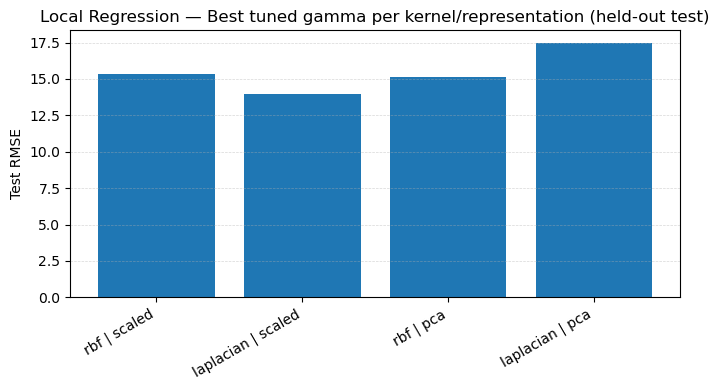

Saved: /Users/dimanavihrenova/Desktop/kernel-regression-dim-reduction/results/figures/local_regression/test_rmse_best_configs.png


In [18]:
# Summary plot: test RMSE for best configs

fig, ax = plt.subplots(figsize=(7, 4))
plot_df = results_df.copy()
plot_df["label"] = plot_df["kernel"] + " | " + plot_df["representation"]

ax.bar(plot_df["label"], plot_df["test_rmse"])
ax.set_ylabel("Test RMSE")
ax.set_title("Local Regression — Best tuned gamma per kernel/representation (held-out test)")
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
ax.grid(True, axis="y", linestyle="--", linewidth=0.5, alpha=0.5)

fig.tight_layout()
fig_path = FIG_DIR / "test_rmse_best_configs.png"
fig.savefig(fig_path, dpi=200)
plt.show()
print(f"Saved: {fig_path}")